In [1]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertTokenizerFast, BertForTokenClassification, Trainer, TrainingArguments, EvalPrediction
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
import torch
from collections import Counter
import matplotlib.pyplot as plt
from seqeval.metrics import classification_report


In [2]:
# Load the dataset
file_path = r"ner dataset\data\ner_dataset.csv"  # Replace 
data = pd.read_csv(file_path, encoding='latin1',low_memory=True)
# data

In [3]:

# Drop the POS column
data = data.drop(columns=["POS"])
data.to_csv("ner_dataset_without_POS.csv", index=False)


In [4]:
df=data
# Remove rows with missing values in the 'Word' column
df = df.dropna(subset=['Word'])

print("dataFramne aftre dropping NA values",len(df))


# Fill Sentence # values downward
df["Sentence #"] = df["Sentence #"].fillna(method="ffill")

# Drop all rows containing the special character "�"
df = df[~df.applymap(lambda x: '�' in str(x)).any(axis=1)]


print("dataFramne aftre removing special char",len(df))

# print(df)

dataFramne aftre dropping NA values 1048565


C:\Users\Manika Sinha\AppData\Local\Temp\ipykernel_28700\523715560.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Sentence #"] = df["Sentence #"].fillna(method="ffill")
C:\Users\Manika Sinha\AppData\Local\Temp\ipykernel_28700\523715560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sentence #"] = df["Sentence #"].fillna(method="ffill")
C:\Users\Manika Sinha\AppData\Local\Temp\ipykernel_28700\523715560.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df[~df.applymap(lambda x: '�' in str(x)).any(axis=1)]


dataFramne aftre removing special char 1048565


In [5]:
#Check the Sentenbces structure
df.head(20)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [6]:
unique_tags = df.Tag.unique()
sorted_unique_tags = sorted(unique_tags, reverse=True)
print(sorted_unique_tags)

['O', 'I-tim', 'I-per', 'I-org', 'I-nat', 'I-gpe', 'I-geo', 'I-eve', 'I-art', 'B-tim', 'B-per', 'B-org', 'B-nat', 'B-gpe', 'B-geo', 'B-eve', 'B-art']


In [7]:
tag2id = {tag: idx for idx, tag in enumerate(sorted_unique_tags)}
id2tag = {idx: tag for tag, idx in tag2id.items()}

In [8]:
print("tag2id", tag2id) 

print("id2tag", id2tag)

tag2id {'O': 0, 'I-tim': 1, 'I-per': 2, 'I-org': 3, 'I-nat': 4, 'I-gpe': 5, 'I-geo': 6, 'I-eve': 7, 'I-art': 8, 'B-tim': 9, 'B-per': 10, 'B-org': 11, 'B-nat': 12, 'B-gpe': 13, 'B-geo': 14, 'B-eve': 15, 'B-art': 16}
id2tag {0: 'O', 1: 'I-tim', 2: 'I-per', 3: 'I-org', 4: 'I-nat', 5: 'I-gpe', 6: 'I-geo', 7: 'I-eve', 8: 'I-art', 9: 'B-tim', 10: 'B-per', 11: 'B-org', 12: 'B-nat', 13: 'B-gpe', 14: 'B-geo', 15: 'B-eve', 16: 'B-art'}


In [9]:
# Group by sentence and aggregate words and tags into lists
# Group by sentence and aggregate
result = df.groupby("Sentence #").agg(
    Sentence=('Word', ' '.join),  # Combine words into a sentence
    Tags=('Tag', ' '.join)       # Combine tags into a single string
).reset_index()

# Display the resulting DataFrame
print(result)

            Sentence #                                           Sentence  \
0          Sentence: 1  Thousands of demonstrators have marched throug...   
1         Sentence: 10  Iranian officials say they expect to get acces...   
2        Sentence: 100  Helicopter gunships Saturday pounded militant ...   
3       Sentence: 1000  They left after a tense hour-long standoff wit...   
4      Sentence: 10000  U.N. relief coordinator Jan Egeland said Sunda...   
...                ...                                                ...   
47944   Sentence: 9995  Opposition leader Mir Hossein Mousavi has said...   
47945   Sentence: 9996  On Thursday , Iranian state media published a ...   
47946   Sentence: 9997  Following Iran 's disputed June 12 elections ,...   
47947   Sentence: 9998  Since then , authorities have held public tria...   
47948   Sentence: 9999  The United Nations is praising the use of mili...   

                                                    Tags  
0      O O O O O

In [10]:
# Alternatively, using tail()
print(result.tail(1))

           Sentence #                                           Sentence  \
47948  Sentence: 9999  The United Nations is praising the use of mili...   

                                                    Tags  
47948  O B-org I-org O O O O O O O O O O O O O O B-ti...  


In [11]:
# Extract the numeric part of the 'Sentence #' column for sorting
result['Sentence_Num'] = result['Sentence #'].str.extract(r'(\d+)').astype(int)

# Sort the DataFrame by the extracted numeric column
sorted_grouped = result.sort_values(by='Sentence_Num').drop(columns=['Sentence_Num'])

# Reset the index after sorting
sorted_grouped = sorted_grouped.reset_index(drop=True)

# Display the first few rows to confirm sorting
print(sorted_grouped.head())

    Sentence #                                           Sentence  \
0  Sentence: 1  Thousands of demonstrators have marched throug...   
1  Sentence: 2  Families of soldiers killed in the conflict jo...   
2  Sentence: 3  They marched from the Houses of Parliament to ...   
3  Sentence: 4  Police put the number of marchers at 10,000 wh...   
4  Sentence: 5  The protest comes on the eve of the annual con...   

                                                Tags  
0  O O O O O O B-geo O O O O O B-geo O O O O O B-...  
1  O O O O O O O O O O O O O O O O O O B-per O O ...  
2                O O O O O O O O O O O B-geo I-geo O  
3                      O O O O O O O O O O O O O O O  
4  O O O O O O O O O O O B-geo O O B-org I-org O ...  


In [12]:
print(sorted_grouped.tail(1))

            Sentence #                                         Sentence  \
47948  Sentence: 47959  Indian forces said they responded to the attack   

                      Tags  
47948  B-gpe O O O O O O O  


In [13]:
#Function to validate the word-tag alignment
def validate_word_tag_alignment(df):
    # Check alignment for each row
    validation_results = df.apply(
        lambda row: len(row["Sentence"].split()) == len(row["Tags"].split()), axis=1
    )
    if validation_results.all():
        print("Validation successful: All sentences and tags are aligned.")
        return[]
    else:
        mismatched_rows = df[~validation_results]
        print("Validation failed: Some rows have mismatched words and tags.")
        print(mismatched_rows)
        return mismatched_rows.index.tolist()

# Validate the DataFrame
rowsWithSpclChar = validate_word_tag_alignment(sorted_grouped)


Validation failed: Some rows have mismatched words and tags.
            Sentence #                                           Sentence  \
76        Sentence: 77  " And I think they 'll want a one-stop shop in...   
10050  Sentence: 10052  In a telephone interview to discuss the issues...   
19814  Sentence: 19818  He says they and about 300 party supporters ar...   
47581  Sentence: 47592  U.S. weather forecasters say Hurricane Wilma h...   

                                                    Tags  
76     O O O O O O O O O O O O O O O O O O O O O O O ...  
10050  O O O O O O O O O O O O O B-org O B-per I-per ...  
19814  O O O O O O O O O O O O O O O O O O O O O O O ...  
47581  B-geo O O O O O O O O O O O O O O O O O O O O ...  


In [14]:
# # Drop the specified rows using their indices
df_cleaned = sorted_grouped.drop(rowsWithSpclChar, errors='ignore')

print(df_cleaned)

print("Some rows have mismatched words and tags",len(df_cleaned))

            Sentence #                                           Sentence  \
0          Sentence: 1  Thousands of demonstrators have marched throug...   
1          Sentence: 2  Families of soldiers killed in the conflict jo...   
2          Sentence: 3  They marched from the Houses of Parliament to ...   
3          Sentence: 4  Police put the number of marchers at 10,000 wh...   
4          Sentence: 5  The protest comes on the eve of the annual con...   
...                ...                                                ...   
47944  Sentence: 47955  Indian border security forces are accusing the...   
47945  Sentence: 47956  Indian officials said no one was injured in Sa...   
47946  Sentence: 47957  Two more landed in fields belonging to a nearb...   
47947  Sentence: 47958  They say not all of the rockets exploded upon ...   
47948  Sentence: 47959    Indian forces said they responded to the attack   

                                                    Tags  
0      O O O O O

Remove this line as this is just to pretrain model on very limited rows

In [15]:
df_cleaned=sorted_grouped[:10000]
df = df_cleaned

In [16]:
# Extract the tags from the DataFrame
tags = df['Tags'].apply(lambda x: x.split())

# Flatten the list of tags
all_tags = [tag for sublist in tags for tag in sublist]

In [17]:
# Count the occurrences of each tag
tag_counts = Counter(all_tags)

# Print the tag counts
print(tag_counts)

Counter({'O': 184908, 'B-geo': 7713, 'B-tim': 4115, 'B-org': 4066, 'I-per': 3747, 'B-gpe': 3611, 'B-per': 3583, 'I-org': 3290, 'I-geo': 1576, 'I-tim': 1245, 'B-art': 112, 'B-eve': 89, 'I-eve': 71, 'I-gpe': 68, 'I-art': 65, 'B-nat': 53, 'I-nat': 22})


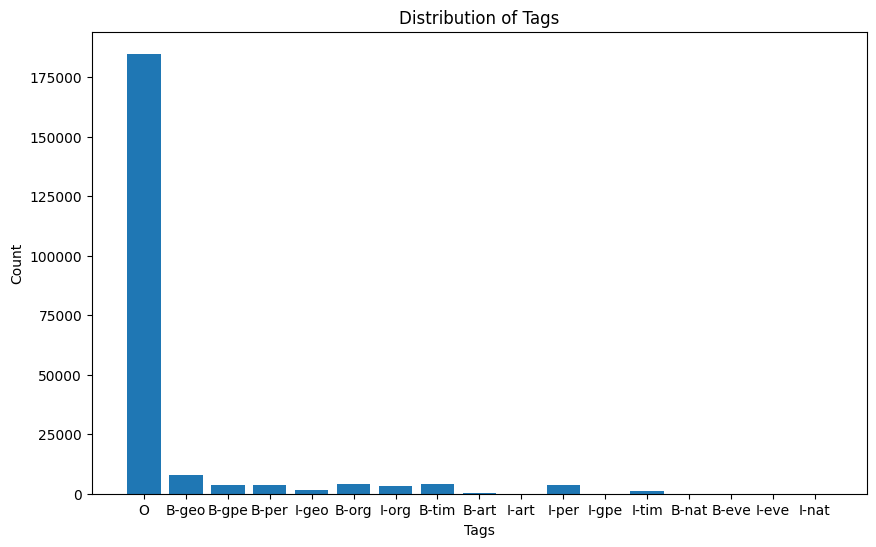

In [18]:
# Plot the distribution of tags
plt.figure(figsize=(10, 6))
plt.bar(tag_counts.keys(), tag_counts.values())
plt.xlabel('Tags')
plt.ylabel('Count')
plt.title('Distribution of Tags')
plt.show()

In [19]:
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

In [20]:
def tokenize_and_align_labels(sentence, labels):
    # Tokenize the sentence
    tokenized_inputs = tokenizer(
        sentence.split(),  # Pre-tokenized input
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors="pt"
    )
    word_ids = tokenized_inputs.word_ids()
    aligned_labels = []
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            aligned_labels.append(-100)
        elif word_idx != previous_word_idx:
            aligned_labels.append(tag2id[labels[word_idx]])
        else:
            aligned_labels.append(tag2id[labels[word_idx]] if word_idx < len(labels) else -100)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = torch.tensor(aligned_labels, dtype=torch.long)
    return tokenized_inputs

In [21]:
# Tokenize and align labels for the dataset
tokenized_dataset = [
    tokenize_and_align_labels(sentence, label.split()) for sentence, label in zip(df['Sentence'], df['Tags'])
]

In [22]:
tokenized_dataset[2]

{'input_ids': tensor([[  101,  1220,  9639,  1121,  1103, 16862,  1104,  2901,  1106,   170,
         11158,  1107, 11878,  1670,   119,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [23]:
class NERDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_dataset):
        self.tokenized_dataset = tokenized_dataset

    def __len__(self):
        return len(self.tokenized_dataset)

    def __getitem__(self, idx):
        item = self.tokenized_dataset[idx]
        return {key: val.squeeze() for key, val in item.items()}



In [24]:
# Create the dataset objects
dataset = NERDataset(tokenized_dataset)

In [25]:
dataset

In [26]:
# Split the data into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = int(0.2 * len(dataset))
# test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print("train Dataset size",len(train_dataset))
print("val Dataset size",len(val_dataset))
print("test Dataset size",len(test_dataset))

train Dataset size 7000
val Dataset size 1000
test Dataset size 2000


In [27]:
train_dataset[0]

{'input_ids': tensor([  101,  1124,  1163,  2029, 10193,  1116,  1209,  1136,  1129, 21073,
          1181,  1120,  1155,   117,  1105,  1393,  7705,  1150,  7906,  1147,
          1739,  1209,  1129,  6576,  1154,  1103,  1569,  7965,   119,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [28]:
# Load the model
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(tag2id))

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=10,
    save_total_limit=2
)



Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Manika Sinha\Sapient_Case_Study\Case Study NER\Case Study NER\.venv\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)

    # Flatten the arrays
    true_labels = labels.flatten()
    true_predictions = predictions.flatten()

    # Remove ignored index (usually padding tokens)
    mask = true_labels != -100
    true_labels = true_labels[mask]
    true_predictions = true_predictions[mask]

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average="weighted", zero_division=0)
    accuracy = accuracy_score(true_labels, true_predictions)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [30]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



C:\Users\Manika Sinha\AppData\Local\Temp\ipykernel_28700\2054015023.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss


In [ ]:
# Evaluate the model on the validation dataset
eval_results = trainer.evaluate(eval_dataset=val_dataset)

# Print the evaluation results
print("Evaluation results:", eval_results)

In [ ]:
# Get predictions for the validation dataset
predictions, labels, _ = trainer.predict(val_dataset)

# Convert predictions to tag names
predicted_tags = np.argmax(predictions, axis=2)

# Remove padding tokens using the attention mask
attention_masks = [val_dataset[i]['attention_mask'].numpy() for i in range(len(val_dataset))]
predicted_tags = [[id2tag[pred] for pred, mask in zip(preds, mask) if mask] for preds, mask in zip(predicted_tags, attention_masks)]
true_tags = [[id2tag[label] if label != -100 else 'O' for label, mask in zip(label_seq, mask) if mask] for label_seq, mask in zip(labels, attention_masks)]

# Create a DataFrame with actual tags and predicted tags
eval_df = pd.DataFrame({
    'Sentence': [tokenizer.decode(val_dataset[i]['input_ids'], skip_special_tokens=True) for i in range(len(val_dataset))],
    'Actual Tags': [' '.join(tags) for tags in true_tags],
    'Predicted Tags': [' '.join(tags) for tags in predicted_tags]
})

# Print the DataFrame
print(eval_df)

In [78]:
eval_df.to_csv("eval_df.csv", index=False)

In [ ]:
# Convert the 'Tags' column to a list of lists
actual_tags_list = eval_df['Actual Tags'].apply(lambda x: x.split()).tolist()

# Print the result
print(actual_tags_list)

# Convert the 'Tags' column to a list of lists
pred_tags_list = eval_df['Predicted Tags'].apply(lambda x: x.split()).tolist()

# Print the result
print(pred_tags_list)

In [ ]:
# Evaluate the model on the test dataset
test_results = trainer.evaluate(eval_dataset=test_dataset)

# Print the evaluation results
print("Test results:", test_results)

# Get predictions for the test dataset
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to tag names
predicted_tags = np.argmax(predictions, axis=2)

# Remove padding tokens using the attention mask
attention_masks = [test_dataset[i]['attention_mask'].numpy() for i in range(len(test_dataset))]
predicted_tags = [[id2tag[pred] for pred, mask in zip(preds, mask) if mask] for preds, mask in zip(predicted_tags, attention_masks)]
true_tags = [[id2tag[label] if label != -100 else 'O' for label, mask in zip(label_seq, mask) if mask] for label_seq, mask in zip(labels, attention_masks)]

# Create a DataFrame with actual tags and predicted tags
test_df = pd.DataFrame({
    'Sentence': [tokenizer.decode(test_dataset[i]['input_ids'], skip_special_tokens=True) for i in range(len(test_dataset))],
    'Actual Tags': [' '.join(tags) for tags in true_tags],
    'Predicted Tags': [' '.join(tags) for tags in predicted_tags]
})

# Print the DataFrame
print(test_df)

In [76]:
test_df.to_csv("test_df.csv", index=False)

In [ ]:
# Convert the 'Tags' column to a list of lists
actual_tags_list = test_df['Actual Tags'].apply(lambda x: x.split()).tolist()

# Print the result
print(actual_tags_list)

# Convert the 'Tags' column to a list of lists
pred_tags_list = test_df['Predicted Tags'].apply(lambda x: x.split()).tolist()

# Print the result
print(pred_tags_list)